In [1]:
### Relevant Libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Predicting Tennis Win-Rates - Group Report

**Submitted by group 003-31:**
- Arman Drismir
- Rohan Joseph
- Miranda Yin

## Introduction

<!-- 1. Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.
2. Clearly state the question you will try to answer with your project.
3. Identify and describe the dataset that will be used to answer the question. -->

This project aims to analyze tennis win-rates (in one-on-one matches) and player data, for the top 500 tennis players in the world between 2017 to 2019, to build a k-nn model to ***predict whether or not a player will have an above or below average win-rate based on their handedness, height, age, and the number of people their country has sent to participate.***

*Dataset:* https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn

## Methods and Results

#### Reading the Dataset

In [2]:
tennis_raw_data <- read_csv(file = "https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn") %>%
    select(-X1)

head(tennis_raw_data) 

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,NA,⋯,54,34,20,14,10,15,9,3590,16,1977
2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,NA,⋯,52,36,7,10,10,13,16,1977,239,200
2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,NA,⋯,27,15,6,8,1,5,9,3590,40,1050
2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,PR,⋯,60,38,9,11,4,6,239,200,31,1298
2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,NA,⋯,56,46,19,15,2,4,16,1977,18,1855
2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,NA,⋯,54,40,18,15,6,9,40,1050,185,275


*Table 1: Raw Data for the Tennis Game Results for the Top 500 Players (2017 - 2019)*

#### Tidying the Data

We will tidy the data by creating a factor for win-rate, putting each player-observation in their own row, converting the country to its number of participants, converting player's handedness to a factor, and selecting relevant columns.

In [3]:
tennis_data_untidy <- tennis_raw_data %>%
    select(winner_name, winner_hand, winner_age, winner_ht, winner_ioc,
            loser_name, loser_hand, loser_age, loser_ht, loser_ioc)

# calculate win rate:
# get the number of wins for players with at least one
tennis_player_wins <- tennis_data_untidy %>%
    select(winner_name) %>%
    rename(name = winner_name) %>%
    group_by(name) %>%
    summarise(wins = n())
# get the player names with at least one win
players_with_wins <- tennis_player_wins %>%
    pull(var = name)

# get the number of losses for players with at least one
tennis_player_losses <- tennis_data_untidy %>%
    select(loser_name) %>%
    rename(name = loser_name) %>%
    group_by(name) %>%
    summarise(losses = n())
# get the player names with at least one loss
players_with_losses <- tennis_player_losses %>%
    pull(var = name)

# add in the players with zero wins and losses to their tibbles
tennis_all_player_wins <- tennis_player_losses %>%
    filter(!(name %in% players_with_wins)) %>%
    mutate(wins = 0) %>%
    select(name, wins) %>%
    rbind(tennis_player_wins) %>%
    arrange(name)
tennis_all_player_losses <- tennis_player_wins %>%
    filter(!(name %in% players_with_losses)) %>%
    mutate(losses = 0) %>%
    select(name, losses) %>%
    rbind(tennis_player_losses) %>%
    arrange(name) %>%
    rename(loser_name = name)

# calculate win rates
tennis_win_rates <- cbind(tennis_all_player_wins, tennis_all_player_losses) %>%
    mutate(win_rate = wins / (wins + losses)) %>%
    select(name, win_rate)

# get the mean winrate
mean_win_rate <- tennis_win_rates %>%
    pull(win_rate) %>%
    mean()

# classify based on being above or below the average win rate
tennis_win_rates <- tennis_win_rates %>%
    mutate(class = ifelse(win_rate >= mean_win_rate, "above", "below")) %>%
    mutate(class = as_factor(class)) %>%
    select(name, win_rate, class)


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
# tidying data:
all_players <- tennis_win_rates %>%
    pull(name)

# get the data for winning players and losing players
tennis_wins_data <- tennis_data_untidy %>%
    select(winner_name, winner_hand, winner_age, winner_ht, winner_ioc) %>%
    rename(name = winner_name, age = winner_age, height = winner_ht,
           hand = winner_hand, country = winner_ioc)
tennis_losses_data <- tennis_data_untidy %>%
    select(loser_name, loser_hand, loser_age, loser_ht, loser_ioc) %>%
    rename(name = loser_name, age = loser_age, height = loser_ht,
           hand = loser_hand, country = loser_ioc)

# create a tibble of each player without duplicates
tennis_each_data = rbind(tennis_wins_data, tennis_losses_data)
tennis_player_data = tennis_each_data %>%
    filter(FALSE)
for(player_name in all_players) {
    tennis_player_data = tennis_each_data %>%
        filter(name == player_name) %>%
        slice(1) %>%
        rbind(tennis_player_data)
}

# add in the win rates and prepare to assign country size
tennis_data <- tennis_player_data %>%
    arrange(name) %>%
    rename(player_name = name) %>%
    cbind(tennis_win_rates) %>%
    mutate(country_size = 0)

# calculate the size of each country
countries_by_size <- tennis_data %>%
    group_by(country) %>%
    summarize(n = n()) %>%
    arrange(n)

# assign each player their country size based on country
for(c in pull(countries_by_size, country)) {
    n <- countries_by_size %>%
        filter(country == c) %>%
        pull(n)
    n <- n[1]
    tennis_data <- tennis_data %>%
        mutate(country_size = ifelse(country == c, n, country_size))
}

# clean up
tennis_data <- tennis_data %>%
    select(name, hand, age, height, country_size, class) %>%
    mutate(hand = as_factor(hand))

glimpse(tennis_data)

`summarise()` ungrouping output (override with `.groups` argument)



Rows: 337
Columns: 6
$ name         <chr> "Adam Moundir", "Adam Pavlasek", "Adrian Mannarino", "Ad…
$ hand         <fct> U, R, L, R, R, R, L, R, R, R, R, R, R, L, L, R, R, R, U,…
$ age          <dbl> 23.93155, 23.48255, 30.63929, 33.44285, 24.70637, 20.153…
$ height       <dbl> NA, NA, 183, NA, NA, NA, 188, NA, NA, NA, NA, NA, NA, 18…
$ country_size <dbl> 5, 5, 29, 21, 15, 18, 21, 21, 4, 18, 4, 12, 25, 25, 18, …
$ class        <fct> below, above, above, below, below, above, above, below, …


*Table 2: Glimpse of our Tidy Tennis Dataset*

To deal with NA values, we will first print out the proportion of NA values of each column.

In [5]:
#SOURCE: Stack Overflow
#Link: https://stackoverflow.com/questions/24027605/determine-the-number-of-na-values-in-a-column
proportion_of_na <- tennis_data %>%
    mutate(hand = ifelse(hand == "U", NA, hand)) %>%
    sapply(function(y) sum(length(which(is.na(y))))/nrow(tennis_data))
proportion_of_na <- data.frame(Proportion = proportion_of_na)

print(proportion_of_na, nrow = 7)

             Proportion
name          0.0000000
hand          0.1364985
age           0.0000000
height        0.6646884
country_size  0.0000000
class         0.0000000


*Table 3: Proportion of NA values per variable column*

- We will treat unknown players handedness as its own category since it is a categorical variable.
- Unfortunately a large proportion of players have unknown heights, enough that we can't simply remove those observations
- Because the values in the "height" column are **continuous**, we can replace any NA values with the **average** for that class.

In [6]:
mean_height_above_average <- tennis_data %>%
    filter(class == "above") %>%
    pull(height) %>%
    mean(na.rm = TRUE)
mean_height_below_average <- tennis_data %>%
    filter(class == "below") %>%
    pull(height) %>%
    mean(na.rm = TRUE)
tidy_tennis_data <- tennis_data %>%
    mutate(height = ifelse((is.na(height)) & (class == "above"),
                                 mean_height_above_average, height)) %>%
    mutate(height = ifelse((is.na(height)) & (class == "below"), 
                                 mean_height_below_average, height))

head(tidy_tennis_data)

,name,hand,age,height,country_size,class
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,Adam Moundir,U,23.93155,184.8421,5,below
2,Adam Pavlasek,R,23.48255,186.0213,5,above
3,Adrian Mannarino,L,30.63929,183.0000,29,above
4,Adrian Menendez Maceiras,R,33.44285,184.8421,21,below
5,Agustin Velotti,R,24.70637,184.8421,15,below
6,Akira Santillan,R,20.15332,186.0213,18,above


*Table 4: Head of Cleaned Dataset with replaced NA Values*

#### Training and Testing Sets

We will separate the dataset into 75% for training, and 25% for testing. Due to our small dataset, we need to ensure that there is sufficient data for testing while having as much data as we can to train with. So a 75/25 split will leave 80 observations for testing, which should be large enough to get an approximation on the accuracy, while the rest can be used to train. <br>

- A seed is used to ensure reproducibility.

In [7]:
set.seed(1)

tennis_data_split <- initial_split(tidy_tennis_data, prop = 0.75, strata = class)

tennis_training_data <- training(tennis_data_split)
tennis_testing_data <- testing(tennis_data_split)

In [8]:
head(tennis_training_data)

,name,hand,age,height,country_size,class
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,Adam Moundir,U,23.93155,184.8421,5,below
2,Adam Pavlasek,R,23.48255,186.0213,5,above
3,Adrian Mannarino,L,30.63929,183.0000,29,above
4,Adrian Menendez Maceiras,R,33.44285,184.8421,21,below
5,Agustin Velotti,R,24.70637,184.8421,15,below
6,Akira Santillan,R,20.15332,186.0213,18,above


*Table 5: Head of tennis_training_data set*

In [9]:
head(tennis_testing_data)

,name,hand,age,height,country_size,class
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
16,Alex De Minaur,R,19.86858,186.0213,18,above
26,Andrej Martin,R,29.96851,180.0000,6,above
30,Artem Dubrivnyy,U,20.70089,184.8421,12,below
34,Benjamin Bonzi,U,20.96920,186.0213,29,above
35,Benjamin Hassan,U,24.59411,186.0213,22,above
39,Bernard Tomic,R,26.30801,193.0000,18,above


*Table 6: Head of tennis_testing_data set*

#### Summary

We will create some tables to summarize the data and find the proportion of observations in each classification to check if the amounts are roughly equal.

In [10]:
summary_table_class <- tennis_training_data %>%
    select(class) %>%
    group_by(class) %>%
    summarize(n = n()) %>%
    mutate(proportion = n / nrow(tennis_training_data))

summary_table_class

`summarise()` ungrouping output (override with `.groups` argument)



class,n,proportion
<fct>,<int>,<dbl>
below,103,0.4071146
above,150,0.5928854


*Table 7: Number and proportion of people who are above or below the average win rate*

It is approximately 4:6, which is acceptable.

In [11]:
summary_table_quantitative <- tennis_training_data %>%
    select(age, height) %>%
    map_df(~mean(., na.rm = TRUE)) %>%
    rename(mean_age = age, mean_height = height)

summary_table_quantitative

mean_age,mean_height
<dbl>,<dbl>
26.23799,185.5567


*Table 8: Mean value of each of the predictor variables*

In [12]:
player_hand_table <- tennis_training_data %>%
    group_by(hand) %>%
    summarize(count = n()) %>%
    rename(player_handedness = hand)

player_hand_table
# L = Left-handed
# R = Right-handed
# U = Unknown

`summarise()` ungrouping output (override with `.groups` argument)



player_handedness,count
<fct>,<int>
U,33
R,189
L,31


*Table 9: Number of left-, right- and unknown-handed players*

#### Visualization

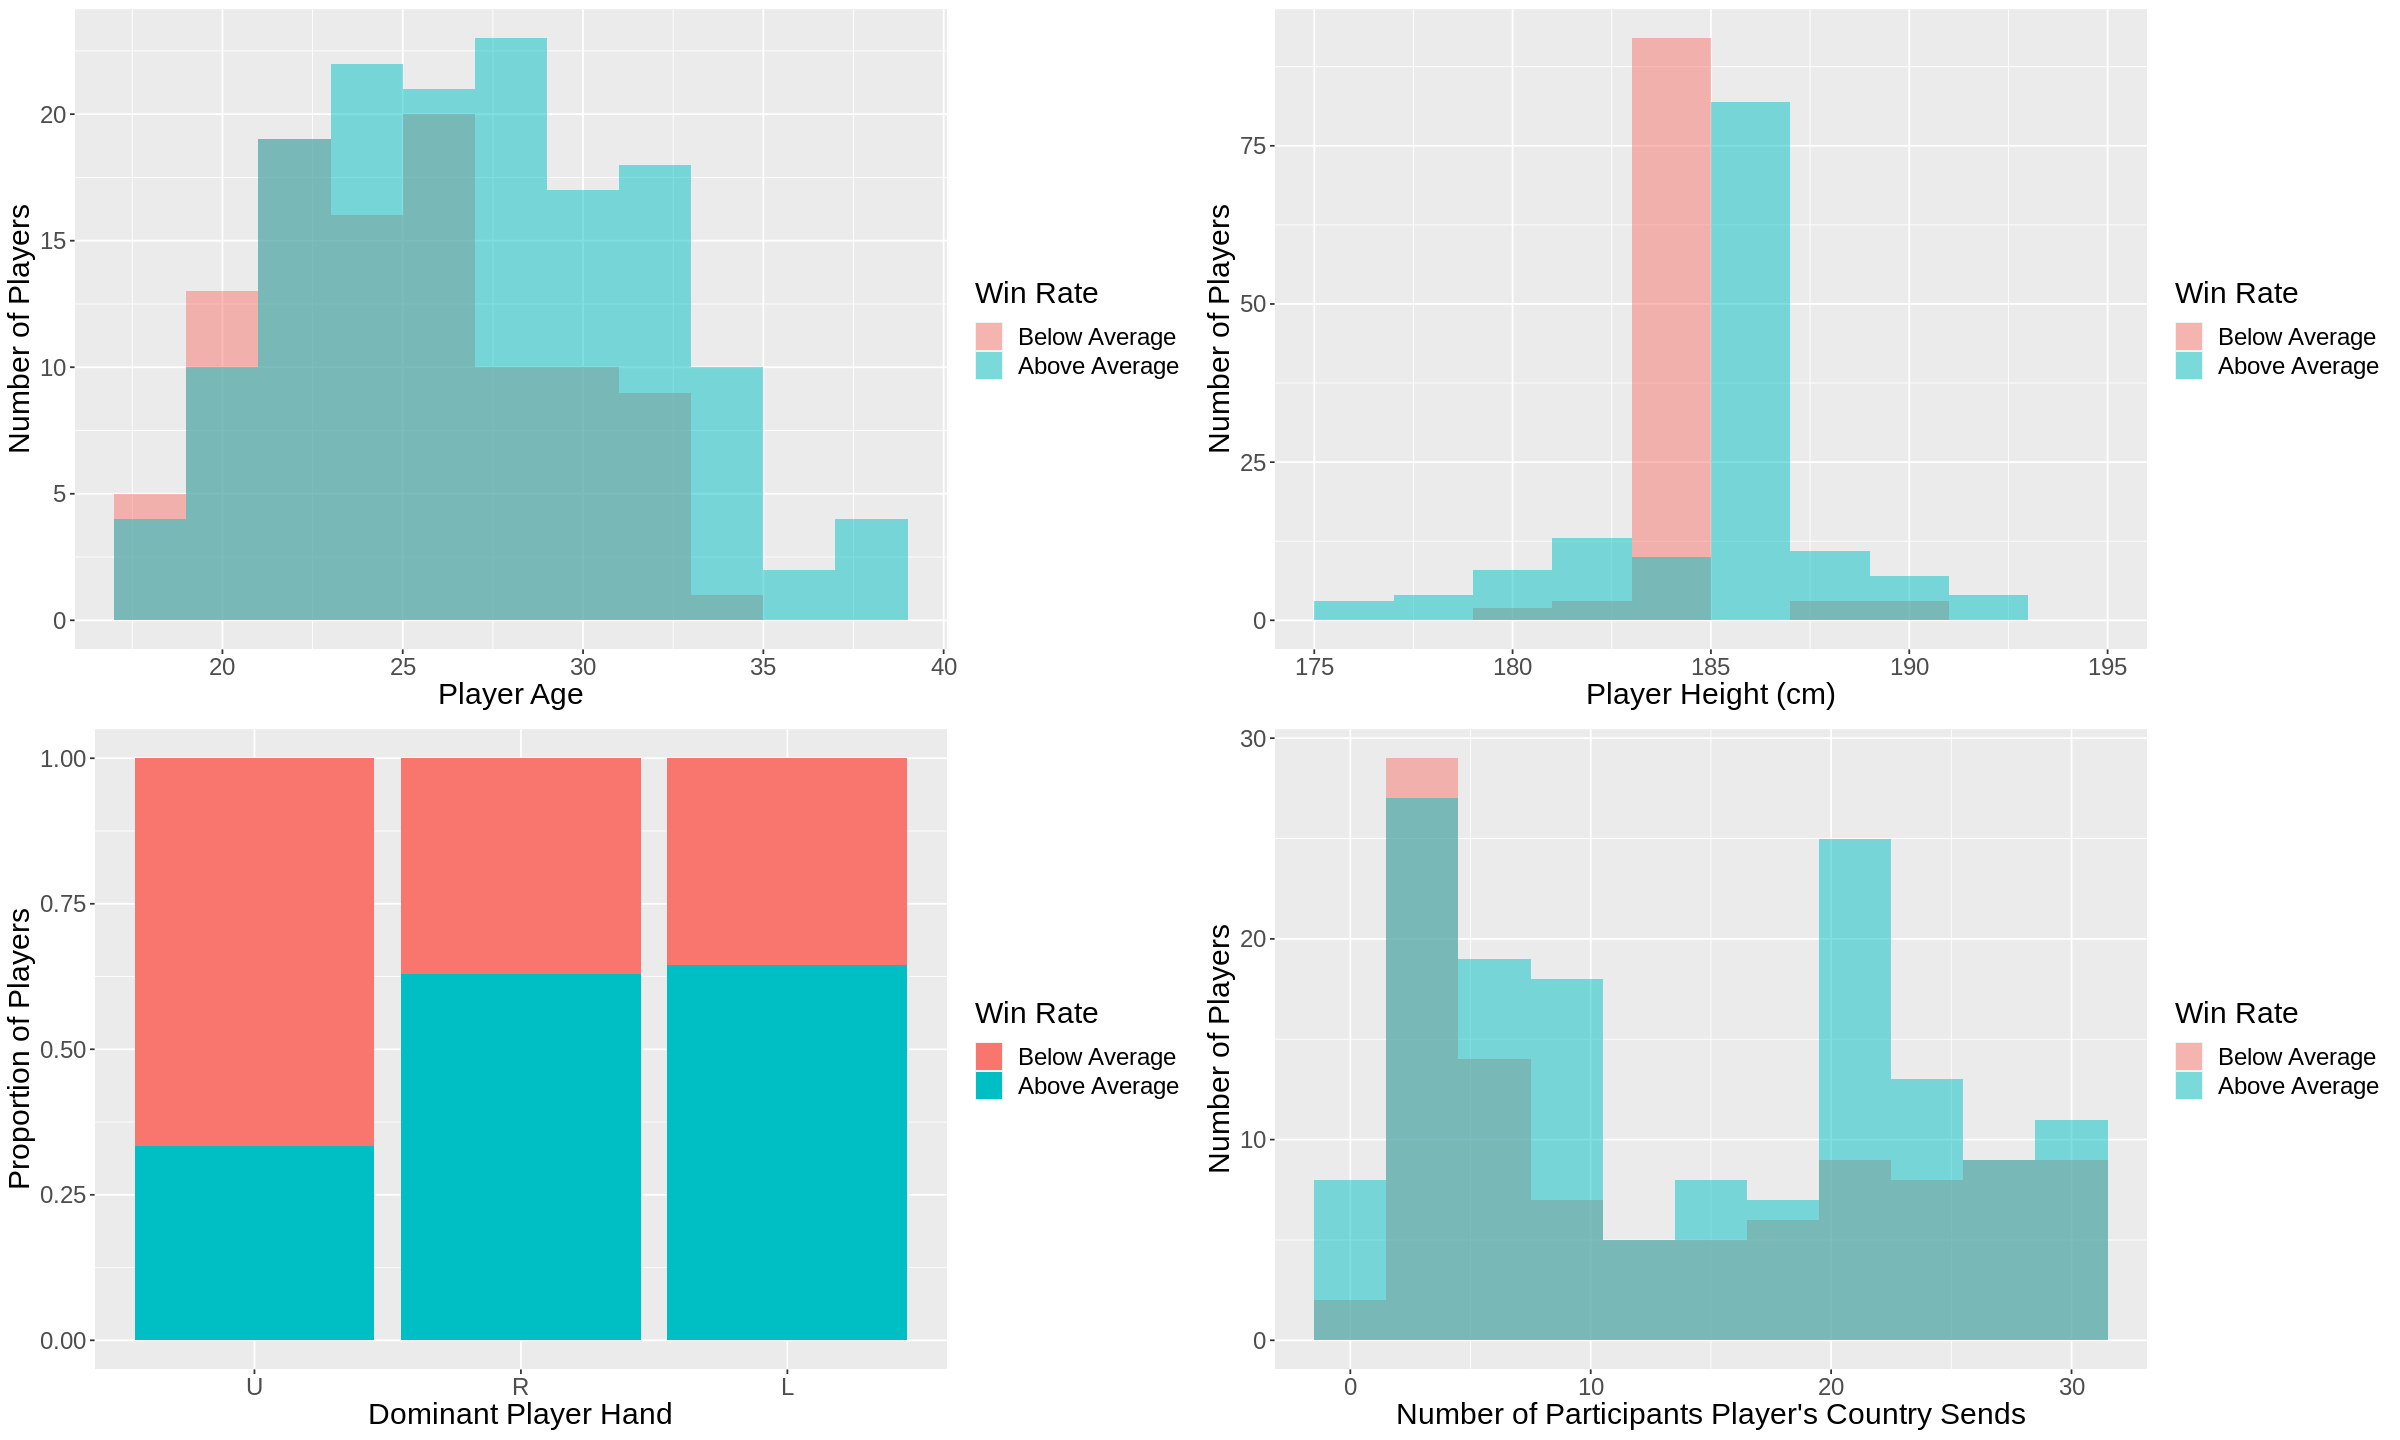

In [13]:
options(repr.plot.width = 20, repr.plot.height = 12)
visualization_data <- tennis_training_data

# Player Age - Historgram
hist_age <- ggplot(visualization_data, 
                  aes(x = age, fill = factor(class))) +
    geom_histogram(position = "identity", binwidth = 2, alpha = 0.5) +
    labs(x = "Player Age", y = "Number of Players", fill = "Win Rate") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Player Height - Historgram
hist_height <- ggplot(visualization_data, 
                     aes(x = height, fill = factor(class))) +
    geom_histogram(position = "identity", alpha = 0.5, breaks = seq(175, 195, by = 2)) +
    labs(x = "Player Height (cm)", y = "Number of Players", fill = "Win Rate", title = ) +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Player Handedness - Bar Plot
plot_hand <- ggplot(visualization_data, 
                   aes(x = factor(hand), fill = factor(class))) +
    geom_bar(position = "fill") +
    labs(x = "Dominant Player Hand", y = "Proportion of Players", fill = "Win Rate") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Number of players countries send - Histogram
plot_countries <- visualization_data %>%
    ggplot(aes(x = country_size, fill = factor(class))) +
        geom_histogram(position = "identity", alpha = 0.5, binwidth = 3) +
        labs(x = "Number of Participants Player's Country Sends", y = "Number of Players", fill = "Win Rate", title = ) +
        scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
        theme(text = element_text(size = 18))


grid.arrange(hist_age, hist_height, plot_hand, plot_countries, nrow = 2)

*Figure 1: Distribution or proportion of the predictor variables*

#### Observations
- The age histogram shows a slight difference favoring older players.
- The “height” histogram shows a small distinct difference, but this is due to having 65% of the height data being from taking the average of the other 35% in that class.
- The "hand" bar-graph shows left and right handed players have above average win rates while those who are unknown have below average win rates.
- The histogram-based on players of a country shows mostly no significant difference, except for a spike around 21 players, however, this is likely due to natural variations.

#### Preprocessing the Tennis Training Data

In order to perform KNN classification, we first need to alter the hand column to be a numerical value instead of a categorical value. Then, we will need to scale our data so that no characteristics are overweight or underweight based on the unit in which they were measured. We have arbitrarily chosen 0 to represent left-handed players (L) and 1 to represent right-handed players (R), and 2 to represent both-handed players (U).
- We have also removed the name column as that has no part to play in our classification model.

Then we will preprocess our data using a recipe. Here we will initialize a recipe for the tennis_training_data set above, specifying that the Class variable is the target, and all other variables are predictors:

In [14]:
set.seed(1234) # set the seed, don't remove this

scaled_training_data <- tennis_training_data %>% 
                        mutate(hand = ifelse(hand == "L", 0, ifelse(hand == "R", 1, 2)))

scaled_training_data <- scaled_training_data %>% 
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(age = as.double(age)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(height = as.double(height)) %>%
                        mutate(country_size = scale(country_size, center = TRUE)) %>%
                        mutate(country_size = as.double(country_size)) %>%
                        select(-name)

scaled_testing_data <- tennis_testing_data %>% 
                        mutate(hand = ifelse(hand == "L", 0, ifelse(hand == "R", 1, 2)))

scaled_testing_data <- scaled_testing_data %>% 
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(age = as.double(age)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(height = as.double(height)) %>%
                        mutate(country_size = scale(country_size, center = TRUE)) %>%
                        mutate(country_size = as.double(country_size)) %>%
                        select(-name)

tennis_recipe <- recipe(class ~ ., data = scaled_training_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

#### KNN Specification for model

In [15]:
set.seed(1234) # set the seed, don't remove this
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Cross validation Specifications

We will be doing a cross-validation on the training data set to select which is the most optimal for our data set for k-nn classification. Since cross-validation helps us evaluate the accuracy of our classifier, we can use cross-validation to calculate an accuracy for each value of k in a reasonable range, and then pick the value of that gives us the best accuracy.

- We will be perform a 5-fold cross-validation on the training set.

In [16]:
set.seed(1234) # set the seed, don't remove this

tennis_vfold <- vfold_cv(scaled_training_data, v = 5, strata = class)

We will then use the tune_grid function to fit the model for each value in a range of parameter values.

- The grid argument specifies that the tuning should try amount of values of the number of neighbors when tuning.
- In this case, we will use a grid value of 10.

In [17]:
set.seed(1234) # set the seed, don't remove this

knn_results <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = tennis_vfold, grid = 10) %>%
       collect_metrics()

head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7903529,5,0.02061701,Model01
2,roc_auc,binary,0.8010000,5,0.02858140,Model01
3,accuracy,binary,0.7311373,5,0.03156281,Model02
3,roc_auc,binary,0.8103651,5,0.02376996,Model02
4,accuracy,binary,0.7311373,5,0.03156281,Model03
4,roc_auc,binary,0.7793571,5,0.02827559,Model03


*Table 10: Head of knn_results*

Now that we have collected the metrics from the workflow analysis, we can plot k vs. accuracy.

#### k vs. accuracy Plot

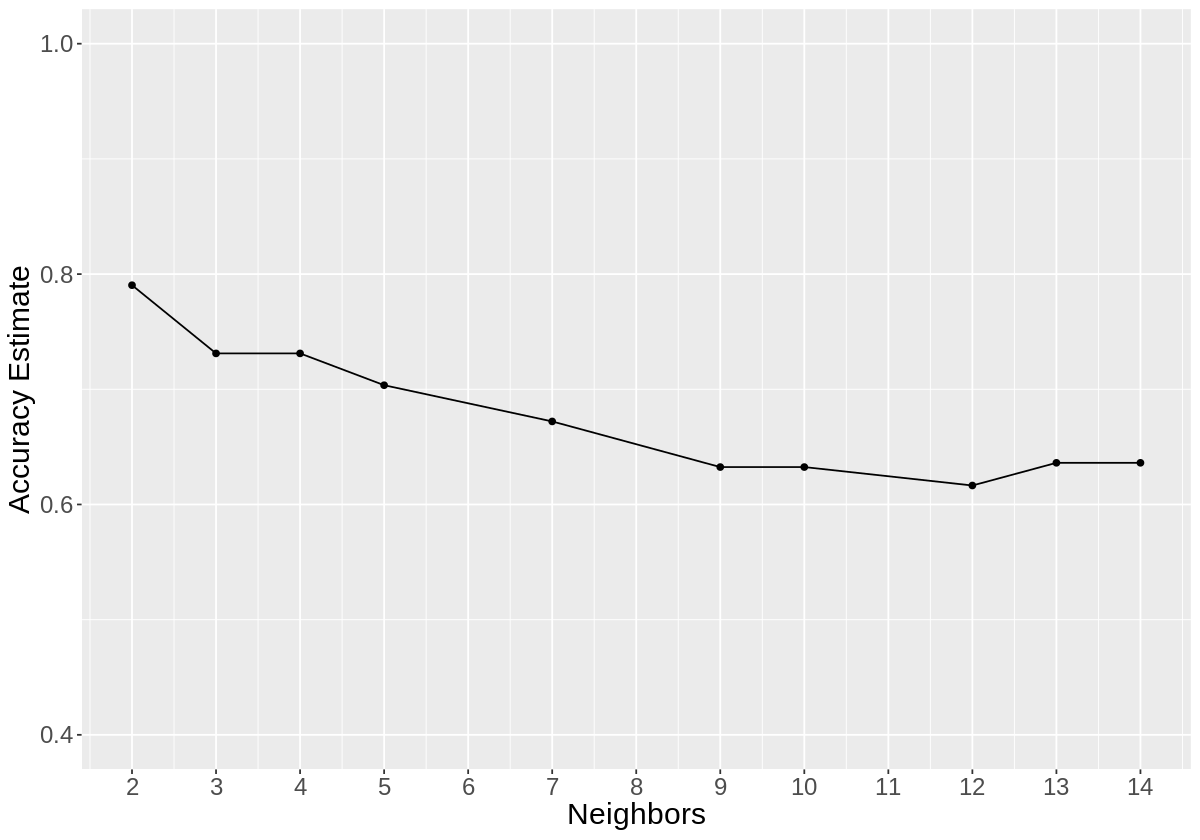

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7)

accuracies <- knn_results %>% 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
    theme(text = element_text(size = 18))

accuracy_versus_k

*Figure 2: k vs. accuracy plot*

A k value of 2 to 4 gives the highest accuracy, due to the accuracy being an estimate that is subject to change with the specific data we're using, either one would work, we will arbitrarily pick 3. We can be sure as cross-validation attempts to give us an unbiased estimate of the k by splitting the data in multiple parts and using the average of the multiple splits as the estimate.

Now that we have explored our data, separated the data into training and testing sets, and applied cross-validation to choose the best , we can build our final model.

In [19]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
            set_engine("kknn") %>%
            set_mode("classification")

tennis_recipe <- recipe(class ~ ., data = scaled_training_data) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = scaled_testing_data)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4047619
Best kernel: rectangular
Best k: 3

#### Testing the Model against the Test Dataset

We will now use the final model final model to predict on the test dataset.
- We will also report the accuracy of this prediction.

In [20]:
tennis_predictions <- predict(knn_fit, scaled_testing_data) %>%
    bind_cols(scaled_testing_data)

head(tennis_predictions)

.pred_class,hand,age,height,country_size,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
above,1,-1.3625761,0.09264294,0.3666135,above
below,1,0.7456206,-0.97197774,-0.7991480,above
below,2,-1.1888456,-0.11584610,-0.2162673,below
above,2,-1.1328404,0.09264294,1.4352282,above
below,2,-0.3761984,0.09264294,0.7552007,above
above,1,-0.0184507,1.32654959,0.3666135,above


*Table 11: Head of tennis_predictions*

In [21]:
tennis_metrics <- tennis_predictions %>% 
    metrics(truth = class, estimate = .pred_class)

tennis_accuracy <- tennis_metrics %>%
    filter(.metric == "accuracy") %>%
    pull(.estimate) * 100

tennis_accuracy

[1] 78.57143

Here, we can see an accuracy of approximately 78% for this prediction. This is not perfect but considering the scope of this project it is pretty impressive.

Here is the confusion matrix for this prediction:

In [22]:
tennis_conf_mat <- tennis_predictions %>%
    conf_mat(truth = class, estimate = .pred_class)

tennis_conf_mat

          Truth
Prediction below above
     below    21     5
     above    13    45

*Table 12: Confusion matrix of predicted results*

## Visualization

To visualize the data, We will create a bar graph of each category in the confusion matrix, and compare that to expected results had our model completely randomly guessed, as well as comparing the distributions of each class between what was predicted and their actual value.

To find the expected values for if the model completely randomly guessed based on having seen 60% of all players be above and 40% of all players be below average, we use the formula that the probability of two independent events (the player actually being above average, and the model assigning the player as being above average) both happening is their probabilities multiplied together.<br>
In our testing data, about 60% of all players are above average.<br>

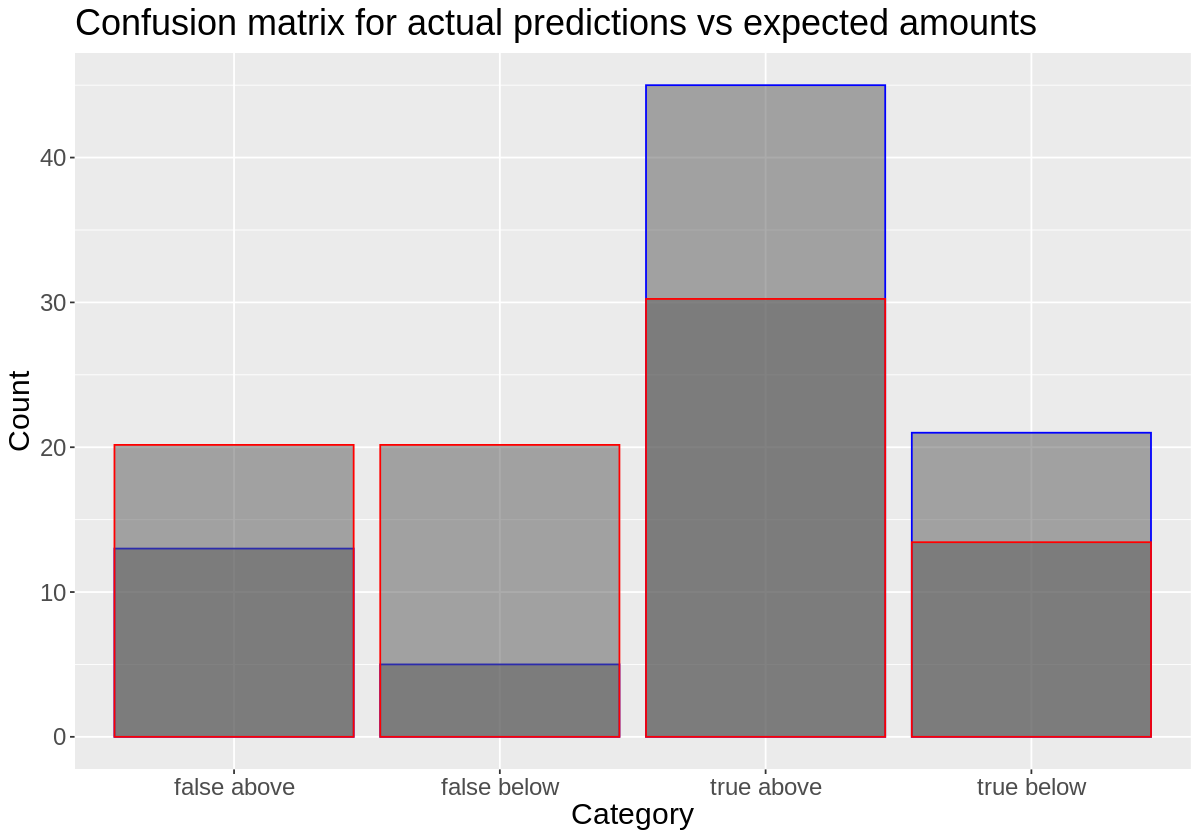

In [23]:
# calculating expected values
expected_true_below <- 0.4*0.4*84
expected_false_below <- 0.4*0.6*84
expected_true_above <- 0.6*0.6*84
expected_false_above <- 0.6*0.4*84

# pulling the values from the confusion matrix
conf_mat_tibble <- tibble(category = c("true below", "false below", "true above", "false above"),
                        n = c(21, 5, 45, 13),
                        expected = c(expected_true_below, expected_false_below,
                                    expected_true_above, expected_false_above))

# Bar graph of confusion matrix
plot_conf_mat <- ggplot(conf_mat_tibble, 
                   aes(x = category)) +
    geom_bar(stat = "identity", alpha = 0.5, aes(y = n), colour = "blue") +
    geom_bar(stat = "identity", alpha = 0.5, aes(y = expected), colour = "red") +
    labs(x = "Category", y = "Count", title = "Confusion matrix for actual predictions vs expected amounts") +
    theme(text = element_text(size = 18))
plot_conf_mat

*Figure 2: Actual vs expected counts for each category of the confusion matrix* <br>
- red = expected predictions if model is random <br>
- blue = actual predictions

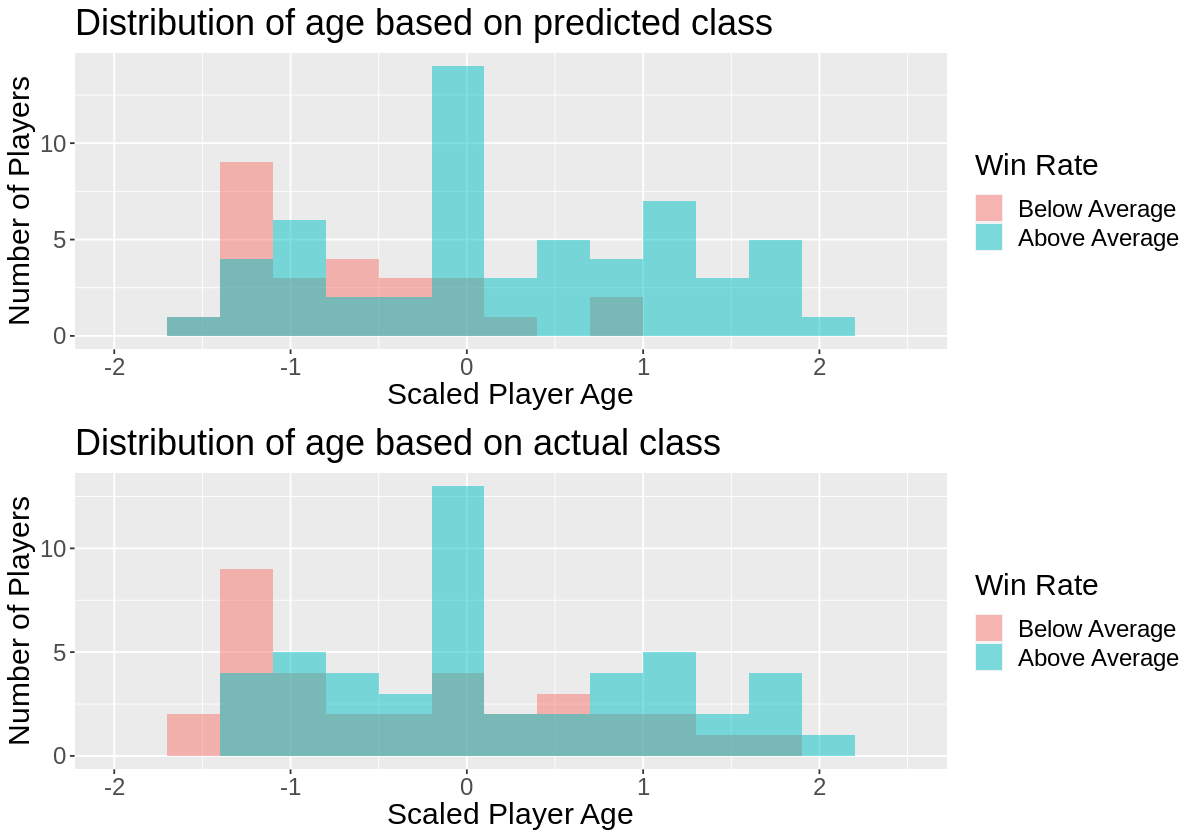

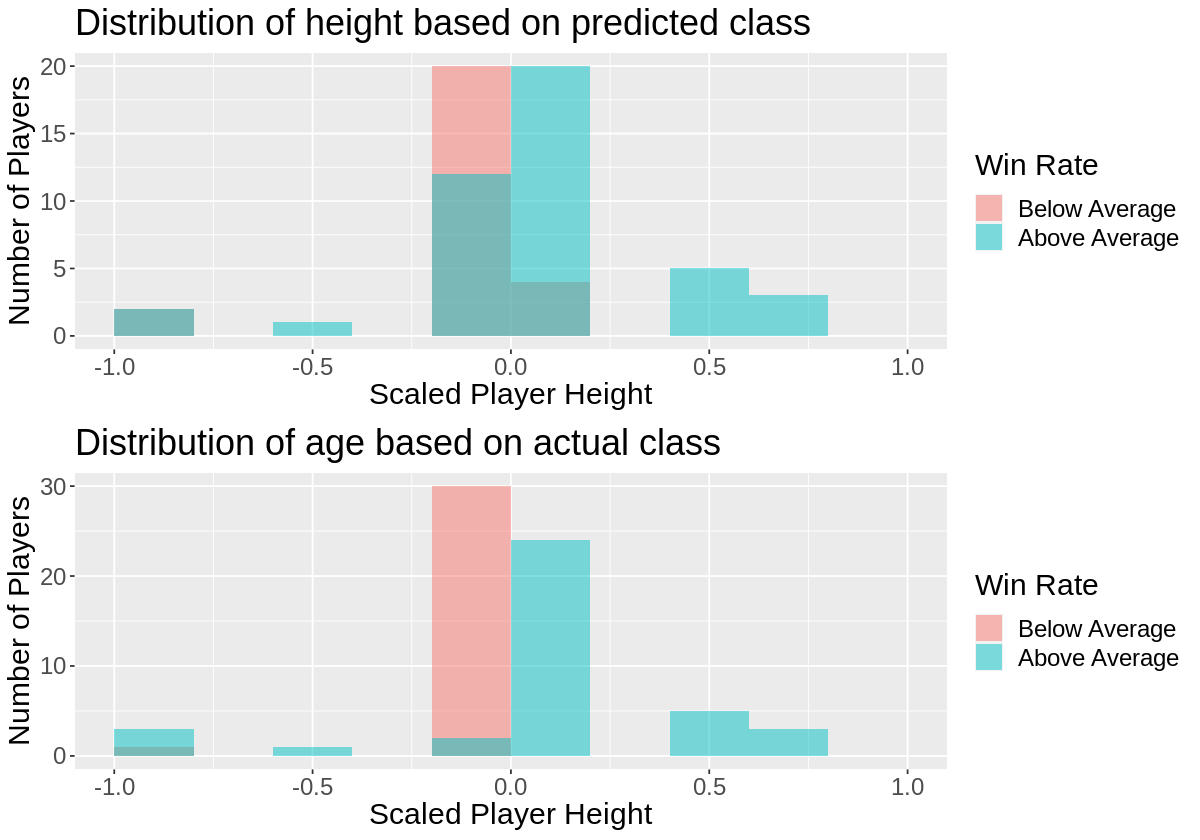

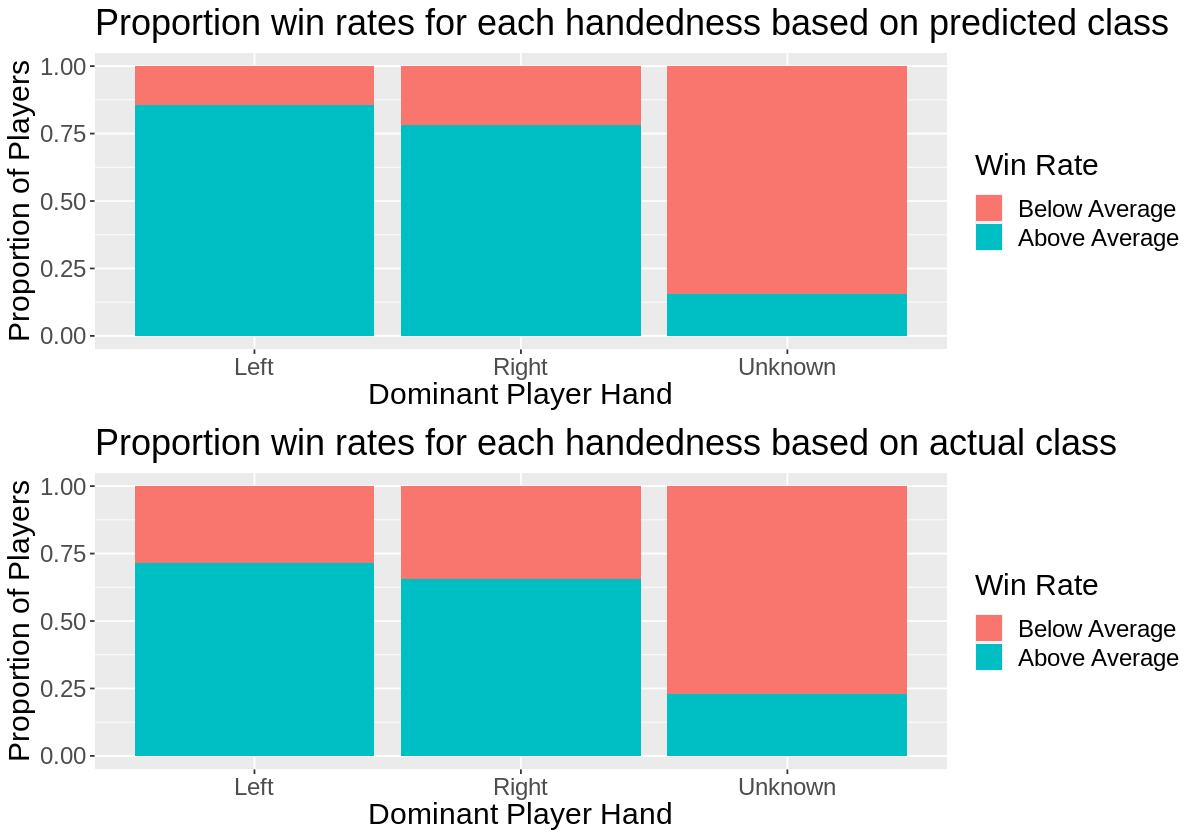

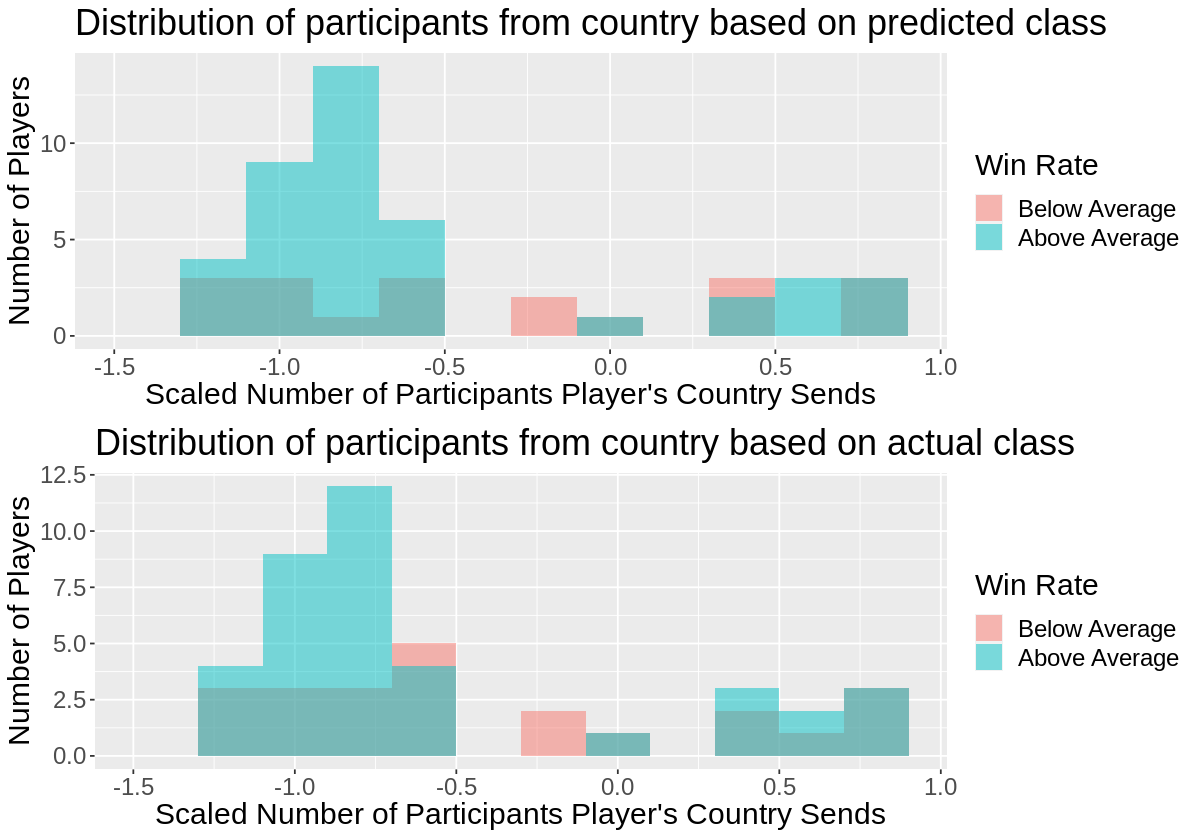

In [24]:

# Player Age - Historgrams
hist_age_predict <- ggplot(tennis_predictions, 
                  aes(x = age, fill = factor(.pred_class))) +
    geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-2, 2.5, by = 0.3)) +
    labs(x = "Scaled Player Age", y = "Number of Players", fill = "Win Rate",
         title = "Distribution of age based on predicted class") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))
hist_age_actual <- ggplot(tennis_predictions, 
                  aes(x = age, fill = factor(class))) +
    geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-2, 2.5, by = 0.3)) +
    labs(x = "Scaled Player Age", y = "Number of Players", fill = "Win Rate",
         title = "Distribution of age based on actual class") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Player Height - Historgrams
hist_height_predict <- ggplot(tennis_predictions, 
                     aes(x = height, fill = factor(.pred_class))) +
    geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-1, 1, by = 0.2)) +
    labs(x = "Scaled Player Height", y = "Number of Players", fill = "Win Rate",
         title = "Distribution of height based on predicted class") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))
hist_height_actual <- ggplot(tennis_predictions, 
                     aes(x = height, fill = factor(class))) +
    geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-1, 1, by = 0.2)) +
    labs(x = "Scaled Player Height", y = "Number of Players", fill = "Win Rate",
         title = "Distribution of age based on actual class") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Player Handedness - Bar Plots
plot_hand_predict <- tennis_predictions %>%
    mutate(hand_label = ifelse(hand == 0, "Left", ifelse(hand == 1, "Right", "Unknown"))) %>%
    ggplot(aes(x = factor(hand_label), fill = factor(.pred_class))) +
        geom_bar(position = "fill") +
        labs(x = "Dominant Player Hand", y = "Proportion of Players", fill = "Win Rate",
             title = "Proportion win rates for each handedness based on predicted class") +
        scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
        theme(text = element_text(size = 18))
plot_hand_actual <- tennis_predictions %>%
    mutate(hand_label = ifelse(hand == 0, "Left", ifelse(hand == 1, "Right", "Unknown"))) %>%
    ggplot(aes(x = factor(hand_label), fill = factor(class))) +
    geom_bar(position = "fill") +
    labs(x = "Dominant Player Hand", y = "Proportion of Players", fill = "Win Rate",
         title = "Proportion win rates for each handedness based on actual class") +
    scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
    theme(text = element_text(size = 18))

# Number of players countries send - Histograms
hist_country_predict <- tennis_predictions %>%
    ggplot(aes(x = country_size, fill = factor(.pred_class))) +
        geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-1.5, 1, by = 0.2)) +
        labs(x = "Scaled Number of Participants Player's Country Sends", y = "Number of Players", fill = "Win Rate", 
            title = "Distribution of participants from country based on predicted class") +
        scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
        theme(text = element_text(size = 18))
hist_country_actual <- tennis_predictions %>%
    ggplot(aes(x = country_size, fill = factor(class))) +
        geom_histogram(position = "identity", alpha = 0.5, breaks = seq(-1.5, 1, by = 0.2)) +
        labs(x = "Scaled Number of Participants Player's Country Sends", y = "Number of Players", fill = "Win Rate",
            title = "Distribution of participants from country based on actual class") +
        scale_fill_discrete(labels = c("above" = "Above Average", "below" = "Below Average")) +
        theme(text = element_text(size = 18))

grid.arrange(hist_age_predict, hist_age_actual, ncol = 1)
grid.arrange(hist_height_predict, hist_height_actual, ncol = 1)
grid.arrange(plot_hand_predict, plot_hand_actual, ncol = 1)
grid.arrange(hist_country_predict, hist_country_actual, ncol = 1)

*Figure 3: plots of the predicted distribution and proportions compared to the actual distributions*

## Discussion

#### Summarize What You Found:
In summary we found that there <b>is a correlation between one’s features</b> (in this context features means one's uncontrollable characteristics ex. height, age, handedness) and <b>whether they are above or below average</b>.

We can see in our bar graph of the confusion matrix that had our model been randomly guessing, it should have resulted in a lot more false belows, and less true results. We can see from our distribution visualizations that the model is not as heavily driven by height as we would have guessed given how we handled NA values, but that it is more driven by age

More specifically we found that we can predict whether they have an above or below average win rate without their match history. Using our predictors (hand, age, country size, height) our model correctly predicts whether a player will be above or below average around 78% of the time, which is higher than the expected 60% had our model randomly guessed. <br>

#### Is that what was expected?

Yes, using the visualisation of our data analysis it was clear that there was a relationship between one’s features and whether they are above or below average. It is surprising though that we are able to predict tennis players standing almost 80% of the time. We thought that the relationship would be more subtle before we trained our model.

#### What Impact Could Our Findings Have & What Future Questions are Presented?

The most obvious question these findings present is whether a tennis player's success is based mostly on luck or hard work. It is no secret that sports select for a certain body type making some of a players success dependent on luck. It is generally accepted that despite these players' lucky genetics they still must work hard to be competitive. If it is acceptable for sports to give some advantage to players with lucky genetics would it be acceptable for sports to only select for genetics? Most would say that it would not be fair for a sport to only favor those with lucky genetics.

So it is <b>fair if a sport favours some player’s genetics</b> but <b>unfair if a sport only selects for genetics</b>.

With this assertion we must then determine to what extent a sport can favour genetics without being unfair. We would say that a sport where two thirds of the players are competitive simply because of their genetics is unfair. There are some examples where sports look as if more than a third of their players are chosen because of genetics. One very damning example is that of Kenyans and their performance in long distance races. People from Kenya show unparalleled dominance in running—most records set by Kenyans are only challenged by other Kenyans. Surely a sport that selects so heavily for one set of genetics is unfair right? Well, it appears that even in this example the genetics of Kenyans are not the reason they are so dominant. (Onywera) The success of Kenyans is because of many things the primary reasons being their high altitude, daily exercise, and low fat diet. (Onywera) I think this example shows that even in the most selective of sports luck is far less important than we would think.

#### What Impact Could Our Findings Have
Our findings are surprising because we were able to fairly accurately predict whether a player would be above or below average. Others research shows that it is not possible to accurately predict a player’s success based on their genetics. This means that our findings conclude something very interesting. This disparity is likely due to how our sample is already of the top players around the world. Which would mean that for players who are already competitive, it is possible to predict if someone will be above or below average based on their features, **thus meaning it takes some luck to get to the very top**, while still being impossible to to predict any random player's general success with these same features.

Word Count: 1867

## References
&nbsp; Guth, L., & Roth, S. (2013, December). Genetic influence on athletic performance. Retrieved April 17, 2021, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3993978/

&nbsp; Vincent O. Onywera, K. (n.d.). Scientists are closer to pinning down why the world's best marathon runner is so good. Retrieved April 17, 2021, from https://qz.com/africa/1628684/why-kenyans-keep-winning-marathons-long-distance 